In [53]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from collections import namedtuple
from scipy.special import logsumexp

### Model

$$X_t = \phi{X_{t-1}} + \sigma W_t$$

$$Y_t = X_t + V_t$$

$$W_t \sim N(0, 1)$$
$$V_t \sim N(0, 0.5^2)$$

In [54]:
v_sigma = 0.5

In [61]:
# simulate
def simulate(T, phi, sigma, seed=0):
    np.random.seed(seed)
    x = np.zeros(T)
    x[0] = np.random.normal()

    for t in range(1, T):
        x[t] = np.random.normal(loc=phi * x[t - 1], scale=sigma)
    y = np.random.normal(loc=x, scale=v_sigma, size=T)

    return x, y

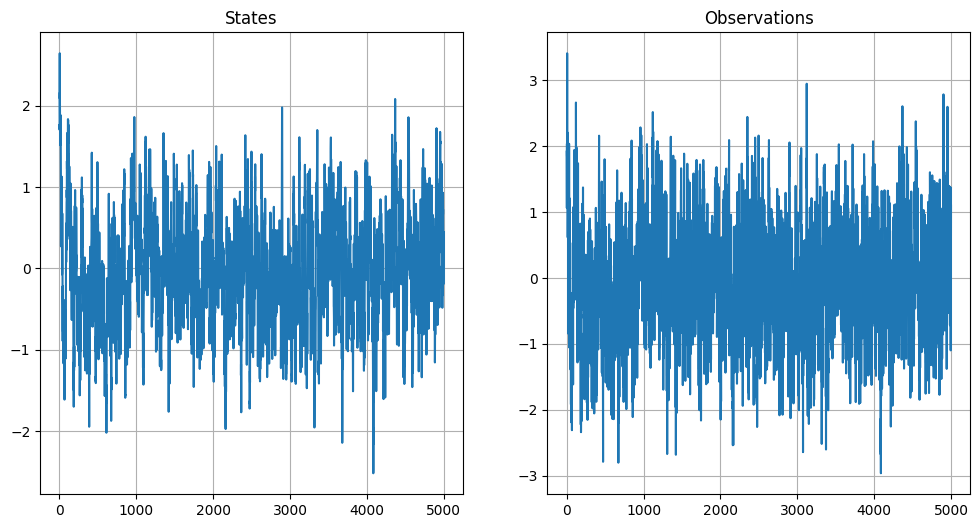

In [67]:
T= 5000 # time steps
phi = 0.9
sigma= 0.3
states, observations = simulate(T, phi, sigma)
fig, ax = plt.subplots(figsize=(12, 6),ncols=2, nrows=1)
ax[0].plot(states)
ax[0].set_title('States')
ax[0].grid()
ax[1].plot(observations)
ax[1].set_title('Observations')
ax[1].grid()

In [68]:
def q(y, x):
    return st.norm.pdf(y, loc=x, scale=v_sigma)


def log_q(y, x):
    return st.norm.logpdf(y, loc=x, scale=v_sigma)


def p(x_2, x_1, phi, sigma):
    return st.norm.pdf(x_2, loc=phi * x_1, scale=sigma)


def resample_propogate_log(N, observation, particles, phi, sigma):
    logw = log_q(observation, particles)
    logw -= logsumexp(logw)
    w = np.exp(logw)
    s = np.sum(w)

    if s == 0 or not np.isfinite(s):
        w = np.ones(N) / N
    else:
        w /= s

    resamples = np.random.choice(a=particles, size=N, p=w)
    particles = np.random.normal(loc=phi * resamples, scale=sigma)
    return particles


def d_phi(phi, sigma, x_2, x_1):
    return p(x_2, x_1, phi, sigma) * ((x_2 - phi * x_1) / sigma**2 * x_1)


def d_sigma(phi, sigma, x_2, x_1):
    return p(x_2, x_1, phi, sigma) * (-1 / sigma + (x_2 - phi * x_1) ** 2 / sigma**3)


def a(n):
    return 0.05 / (n + 1)**0.6


def estimate_params(T, observations, initial_phi=0.8, initial_sigma=0.5, N=1000, seed=0):
    # initial config
    np.random.seed(seed)
    phi, sigma = initial_phi, initial_sigma
    d = 2  # number of parameters
    Params = namedtuple("Params", "phi sigma")
    params = Params(0, 1)
    particles = np.random.normal(loc=0, size=N)

    weights = 1 / N * np.ones((d, N))

    evolution = [(phi, sigma)]

    for j in range(T - 1):
        observation = observations[j]
        next_particles = resample_propogate_log(N, observation, particles, phi, sigma)
        next_observation = observations[j + 1]
        new_weights = np.empty((d, N))
        for i in range(N):
            normaliser = np.sum(
                (p(next_particles[i], particles, phi, sigma) * q(observation, particles))
            )
            if normaliser == 0:
                continue
            new_weights[params.phi][i] = (
                np.sum(d_phi(phi, sigma, next_particles[i], particles) * q(observation, particles))
                + np.sum(
                    p(next_particles[i], particles, phi, sigma)
                    * q(observation, particles)
                    * weights[params.phi]
                )
            ) / normaliser
            new_weights[params.sigma][i] = (
                np.sum(d_sigma(phi, sigma, next_particles[i], particles) * q(observation, particles))
                + np.sum(
                    p(next_particles[i], particles, phi, sigma)
                    * q(observation, particles)
                    * weights[params.sigma]
                )
            ) / normaliser
        new_weights = new_weights - np.reshape(np.mean(new_weights, axis=1), (d, 1))
        normaliser = np.sum(q(next_observation, next_particles))
        if (
            normaliser != 0
        ):  # normaliser == 0 iff all probabilities are zero
            phi += (
                a(j)
                * np.sum(q(next_observation, next_particles) * new_weights[params.phi])
                / normaliser
            )
            phi = min(max(phi, 0.001), 2)
            sigma += (
                a(j)
                * np.sum(q(next_observation, next_particles) * new_weights[params.sigma])
                / normaliser
            )
            sigma = min(max(sigma, 0.001), 2)

        weights = new_weights
        evolution.append((phi, sigma))

        # print("params:",evolution)
        print(f"Iteration {j + 1}/{T - 1} phi:{phi},sigma:{sigma})")

        particles = next_particles
    return evolution


def estimate_params_vec(T, observations, initial_phi=0.8, initial_sigma=0.3, N=1000, seed=0):
    # initial config
    np.random.seed(seed)
    phi, sigma = initial_phi, initial_sigma
    d = 2  # number of parameters
    Params = namedtuple("Params", "phi sigma")
    params = Params(0, 1)

    prev_p = np.random.normal(loc=0, size=N)

    weights = 1/N * np.ones((d,N))
    # weights = np.zeros((d, N))

    evolution = [(phi, sigma)]

    for j in range(T - 1):
        observation = observations[j]
        next_p = resample_propogate_log(N, observation, prev_p, phi, sigma)
        next_observation = observations[j + 1]
        new_weights = np.empty((d, N))
        P = p(next_p[:, None], prev_p[None, :], phi, sigma)  # (N,N)
        Q = q(observation, prev_p)  # (N,)
        K = P * Q[None, :]  # (N,N)
        normalisers = K.sum(axis=1)
        valid = normalisers > 0
        dphi = d_phi(phi, sigma, next_p[:, None], prev_p[None, :])  # (N,N)
        num_phi = (dphi * Q[None, :]).sum(axis=1) + (
            K * weights[params.phi][None, :]
        ).sum(axis=1)
        dsigma = d_sigma(phi, sigma, next_p[:, None], prev_p[None, :])  # (N,N)

        num_sigma = (dsigma * Q[None, :]).sum(axis=1) + (
            K * weights[params.sigma][None, :]
        ).sum(axis=1)
        new_weights = np.zeros((d, N))

        new_weights[params.phi, valid] = num_phi[valid] / normalisers[valid]
        new_weights[params.sigma, valid] = num_sigma[valid] / normalisers[valid]
        new_weights -= new_weights.mean(axis=1, keepdims=True)
        Q_next = q(next_observation, next_p)
        norm = Q_next.sum()

        if norm > 0:
            phi += a(j) * (Q_next @ new_weights[params.phi]) / norm
            phi = np.clip(phi, 0.001, 2)

            sigma += a(j) * (Q_next @ new_weights[params.sigma]) / norm
            sigma = np.clip(sigma, 0.001, 2)

        weights = new_weights
        evolution.append((phi, sigma))

        # print("params:",evolution)
        print(f"Iteration {j + 1}/{T - 1} phi:{phi},sigma:{sigma})")

        prev_p = next_p
    return evolution

In [69]:
def plot_param_estimation(guesses):
    guesses = np.array(guesses)
    guesses_t = guesses.T

    phis = guesses_t[0]
    sigmas = guesses_t[1]

    fig, ax = plt.subplots()

    ax.plot(phis, label="phi", color="green")
    ax.hlines(
        y=phi, xmin=0, xmax=len(phis), label="true phi", linestyle="dashed", color="green"
    )

    ax.plot(sigmas, label="sigma", color="blue")
    ax.hlines(
        y=sigma,
        xmin=0,
        xmax=len(phis),
        label="true sigma",
        linestyle="dashed",
        color="blue",
    )

    fig.legend()
    ax.grid()
    fig.set_figheight(6)
    fig.set_figwidth(10)

In [70]:
guesses = estimate_params_vec(T=1000, observations=observations, N=1000)

Iteration 1/999 phi:0.7999407942523049,sigma:0.27394949772937793)
Iteration 2/999 phi:0.7957907244624585,sigma:0.24989133953215834)
Iteration 3/999 phi:0.9862205226460474,sigma:0.32002396444427617)
Iteration 4/999 phi:1.0859221139935742,sigma:0.367515979650309)
Iteration 5/999 phi:1.208368168475899,sigma:0.4343554833999218)
Iteration 6/999 phi:1.3279757131137797,sigma:0.494491686675696)
Iteration 7/999 phi:1.1491171016120578,sigma:0.45781979374617016)
Iteration 8/999 phi:0.9924379374970819,sigma:0.5074033904740011)
Iteration 9/999 phi:0.9432552592119379,sigma:0.5172801907550365)
Iteration 10/999 phi:0.9571918941912619,sigma:0.5037950848641153)
Iteration 11/999 phi:0.9300744554309329,sigma:0.49655270238050975)
Iteration 12/999 phi:0.9473441079497475,sigma:0.4871556674359648)
Iteration 13/999 phi:0.8995669626954622,sigma:0.49162619366756677)
Iteration 14/999 phi:0.90214729112499,sigma:0.48049198689272365)
Iteration 15/999 phi:0.9101952201243991,sigma:0.47291134220223213)
Iteration 16/999

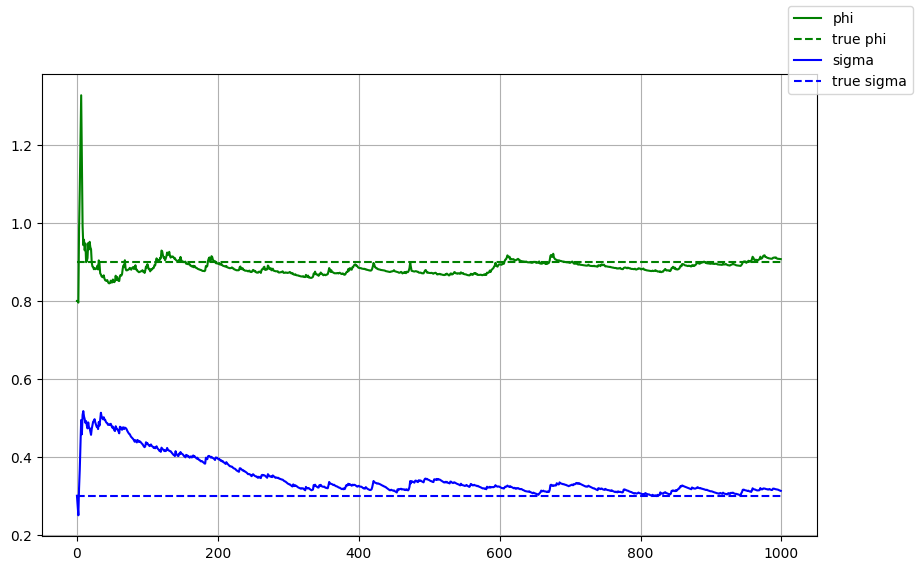

In [71]:
plot_param_estimation(guesses)

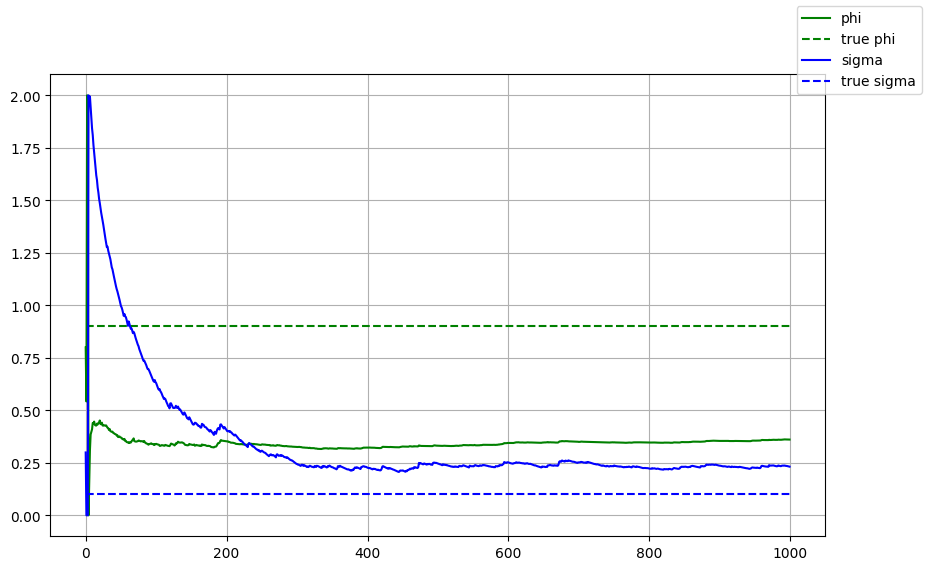

In [50]:
plot_param_estimation(guesses)